# Momentum in Crypto Using Directional Index Strategy 

Exploring optimization of the Directional Index Strategy. For more details, see project README.md!

In [2]:
from binance.client import Client as bnb_client
import statsmodels.api as sm
from sklearn.preprocessing import QuantileTransformer
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# # Get all USDT trading pairs

# client = bnb_client(tld='US')

# def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
#     data = client.get_historical_klines(symbol,freq,start_ts)
#     columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
#     'num_trades','taker_base_volume','taker_quote_volume','ignore']

#     data = pd.DataFrame(data,columns = columns)
    
#     # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
#     data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     return data 
# # Fetch all trading pairs
# exchange_info = client.get_exchange_info()

# # Extract all symbols that end with "USDT"
# univ = [symbol['symbol'] for symbol in exchange_info['symbols'] if symbol['quoteAsset'] == 'USDT']

# freq = '1d' #technically a period
# px = {}
# vol = {}
# high = {}
# low = {}
# for x in univ:
#     data = get_binance_px(x,freq)
#     px[x] = data.set_index('open_time')['close']
#     vol[x] = data.set_index('open_time')['volume']
#     high[x] = data.set_index('open_time')['high']
#     low[x] = data.set_index('open_time')['low']


# px = pd.DataFrame(px).astype(float)
# px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))

# vol = pd.DataFrame(vol).astype(float)
# vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

# high = pd.DataFrame(high).astype(float)
# high = high.reindex(pd.date_range(high.index[0],high.index[-1],freq=freq))

# low = pd.DataFrame(low).astype(float)
# low = low.reindex(pd.date_range(low.index[0],low.index[-1],freq=freq))

# ret = px.pct_change()

# px.to_pickle('full_usdt_df_'+ freq+'_px.pkl')
# ret.to_pickle('full_usdt_df_'+ freq+'_ret.pkl')
# vol.to_pickle('full_usdt_df_'+ freq+'_vol.pkl')
# high.to_pickle('full_usdt_df_'+ freq+'_high.pkl')
# low.to_pickle('full_usdt_df_'+ freq+'_low.pkl')

In [4]:
# Load data
px = pd.read_pickle('full_usdt_df_1d_px.pkl') #change file based on frequency
ret = pd.read_pickle('full_usdt_df_1d_ret.pkl') #change file based on frequency
vol = pd.read_pickle('full_usdt_df_1d_vol.pkl') #change file based on frequency
high = pd.read_pickle('full_usdt_df_1d_high.pkl') #change file based on frequency
low = pd.read_pickle('full_usdt_df_1d_low.pkl') #change file based on frequency

In [5]:
# Keep "relevant" coins
price_vol = px.mean()*vol.mean()

threshold = 100_000
big_coins = price_vol[price_vol > threshold].index

ret_big = ret[big_coins]

## Functions

Functions used in the strategy

In [6]:
# Define average functions

# Simple moving average
def sma(asset_df, avg_time):
    return asset_df.rolling(window=avg_time).mean()

# Exponential (weighted) moving average
def ema(asset_df, alpha):
    return asset_df.ewm(alpha=alpha, adjust=False).mean()   


In [7]:
# Create a returns object

class returns:

    """Returns object:
       
       Given a portfolio of signals (port) and percent returns of a security (ret), this will output common metrics and variables used in
       performance evaluation and analysis.

       The purify() method performs a linear regression and extracts the residual from that regression. Pass in the appropriate beta for
       your regression.
       """
    
    def __init__(self, port, ret):
        self.port = port
        self.ret = ret

    # Normalize portfolio, usually done before gen_returns()
    def norm(self):
        self.port = self.port.divide(self.port.abs().sum(1),0).fillna(0) # normalize rows

    # Calculate returns and evaluation metrics
    def gen_returns(self, tcost_bps=20, N_trades = 365, print_results=True):
        self.gross_ret = (self.port.shift()*self.ret).sum(1)
        self.to = (self.port.fillna(0) - self.port.shift().fillna(0)).abs().sum(1)
        self.mean_tcost = self.to.mean()*tcost_bps*1e-4
        self.net_ret = self.gross_ret.subtract(self.to*tcost_bps*1e-4,fill_value=0)
        self.mean_gross = self.gross_ret.mean()
        
        if print_results:
            print("Mean gross returns:", self.mean_gross,
             "\nMean tcosts:", self.mean_tcost,
             "\nMean net returns:", self.net_ret.mean(),
             "\nGross Sharpe:", self.gross_ret.mean()/self.gross_ret.std()*np.sqrt(N_trades), 
             "\nNet Sharpe:", self.net_ret.mean()/self.net_ret.std()*np.sqrt(N_trades),
             "\nMean turnover:", self.to.mean())

    # Purify strategy: Does linear regression on chosen beta and outputs alpha and information ratio
    def purify(self, beta, N_trades = 365, print_results=True):
        Y = self.net_ret
        X = beta
        X = sm.add_constant(X)
        
        results = sm.OLS(Y, X).fit()
        self.alpha = results.params['const'] + results.resid
        self.ir = self.alpha.mean()/self.alpha.std()*np.sqrt(N_trades)
        
        if print_results:
            print("params:",
            '\n',results.params,
            "\nt-values:", 
            '\n',results.tvalues,
            '\nInfo Ratio:', self.ir)



In [8]:
# Directional index equations

def di_trend(high, low, close, alpha):

    # Positive directional movement
    pos_dm_condition = (high - high.shift(-1) > low.shift(-1) - low) & (high > high.shift(-1))
    pos_dm = (high - high.shift(-1)).where(pos_dm_condition, 0)

    # Negative directional movement
    neg_dm_condition = (high - high.shift(-1) < low.shift(-1) - low) & (low < low.shift(-1))
    neg_dm = (low.shift(-1) - low).where(neg_dm_condition, 0)

    # True Range
    hl = high - low
    hc = (high - close.shift(-1)).abs()
    cl = (close.shift(-1) - low).abs()   
    stacked = np.stack([hl.values, hc.values, cl.values], axis=0)
    tr = np.max(stacked, axis=0)
    tr = pd.DataFrame(tr, index=high.index, columns=high.columns)

    # Average directional index
    atr = ema(tr, alpha)
    pdi = ema(pos_dm, alpha)/atr
    ndi = ema(neg_dm, alpha)/atr

    di = (pdi-ndi).abs()/(pdi+ndi)
    di_sign = np.sign(pdi-ndi)

    return di, di_sign

# Make trend crossing functions

def trend_crossing(asset, fit, trend, threshold=0.3):
    
    diff = (asset - fit)/fit

    # Detect trend crossing with sign change and threshold on crossing strength and direction
    cross = diff.where(diff.shift()*diff < 0)
    cross = cross.where(trend.abs() >= threshold) 
    cross = cross.mask(cross > 0, 1).mask(cross < 0, -1)
    cross.ffill(inplace=True)  # Forward fill to maintain previous value
    
    return cross.fillna(0)

## Split training data into cross-sectional training set

In [10]:
# Select random columns from high market cap coins
ret_train = ret_big.fillna(0).sample(n=ret_big.shape[1]//2, axis=1, random_state=42)
train_cols = ret_train.columns
high_train= high[train_cols].fillna(0)
low_train = low[train_cols].fillna(0)
close_train = px[train_cols].fillna(0)

Mean gross returns: 0.0021469765180619723 
Mean tcosts: 0.0001657577544039718 
Mean net returns: 0.0019812187636580004 
Gross Sharpe: 1.5508819213844398 
Net Sharpe: 1.4304930994163183 
Mean turnover: 0.08287887720198589
params: 
 const    0.001970
0        0.000508
dtype: float64 
t-values: 
 const    3.267458
0        0.536587
dtype: float64 
Info Ratio: 1.4228378135399058


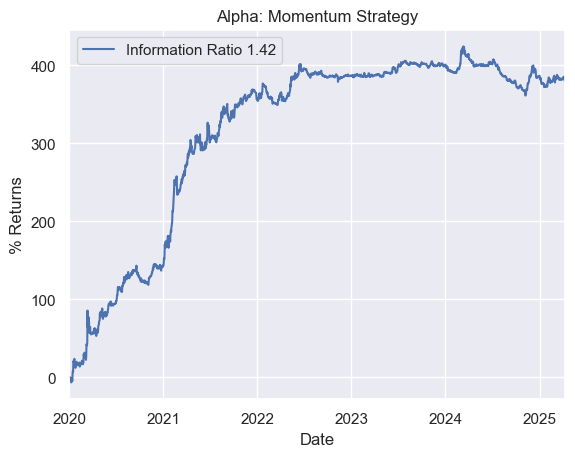

In [11]:
# Make trend
alpha = 0.35 
thresh = 0.25
di = di_trend(high_train,low_train,close_train,alpha)

# Fits for trend
asset = sma(ret_train, 5).cumsum()
fit = ema(ret_train, 0.1).cumsum()

# Momemtum signal
port = trend_crossing(asset, fit, di[0], threshold=0.2)

rets = returns(port, ret)
rets.norm()
rets.gen_returns()

beta = ret_train.sum(1)
rets.purify(beta)

(rets.alpha*100).cumsum().plot(title= f'Alpha: Momentum Strategy', xlabel='Date', ylabel= '% Returns',
                              label = f"Information Ratio {rets.ir:.2f}")
plt.legend()

## Apply to full dataset

In [12]:
# Select random columns from high market cap coins
ret = ret_big.fillna(0)
ret_cols = ret.columns
high = high[ret_cols].fillna(0)
low = low[ret_cols].fillna(0)
close = px[ret_cols].fillna(0)

Mean gross returns: 0.0019512946766146596 
Mean tcosts: 0.00016353193707722516 
Mean net returns: 0.0017877627395374341 
Gross Sharpe: 1.5959272386638366 
Net Sharpe: 1.4615821179073203 
Mean turnover: 0.08176596853861258
params: 
 const    0.001780
0        0.000132
dtype: float64 
t-values: 
 const    3.340759
0        0.316749
dtype: float64 
Info Ratio: 1.4554229508664145


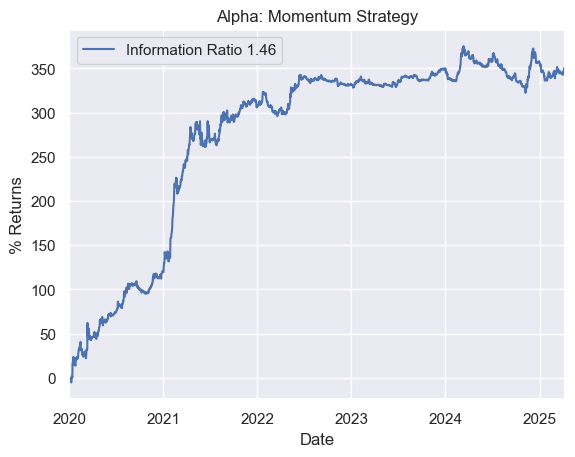

In [13]:
# Make trend
alpha = 0.35 
thresh = 0.25
di = di_trend(high, low, close, alpha)

# Fits for trend
asset = sma(ret, 5).cumsum()
fit = ema(ret, 0.1).cumsum()

# Momemtum signal
port = trend_crossing(asset, fit, di[0], threshold=0.2)

rets = returns(port, ret)
rets.norm()
rets.gen_returns()

beta = ret.sum(1)
rets.purify(beta)

(rets.alpha*100).cumsum().plot(title= f'Alpha: Momentum Strategy', xlabel='Date', ylabel= '% Returns',
                              label = f"Information Ratio {rets.ir:.2f}")
plt.legend()
plt.savefig('Momentum strat')